In [2]:
# Install flory
!pip install flory

In [17]:
import numpy as np
DTYPE = np.float64
import flory
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd
from tqdm import tqdm

In [19]:
def floryHuggins(phi:DTYPE, chi:np.array):
    part_1 = np.sum(phi*np.log(phi))
    part_2 = 0

    for i in range(len(phi)):
        for j in range(i+1, len(phi)):
            part_2 += chi[i, j]*phi[i]*phi[j]

    return part_1 + part_2

In [20]:
# Interaction matrix
chis = np.array([[0, 3.0, 3.0], [3.0, 0.0, 3.0], [3.0, 3.0, 0.0]], dtype = DTYPE)

# Global value of phis
phi_global = np.array([0.4, 0.3, 0.3], dtype = DTYPE)

# Equilibrium 3 phase solution
phases = flory.find_coexisting_phases(3, chis, phi_global)

print("\n" + f"Equlibrium phase volumes: {phases.volumes}")
print("Equlibrium phase concentrations:\n" + f"{phases.fractions}")

Incompressibility   :   0%|          | 0/5.0 [00:00<?, ?it/s]

Field Error         :   0%|          | 0/5.0 [00:00<?, ?it/s]

Volume Error        :   0%|          | 0/5.0 [00:00<?, ?it/s]

Constraint Residue  :   0%|          | 0/5.0 [00:00<?, ?it/s]

Revive Count Left


Equlibrium phase volumes: [0.42639831 0.28680489 0.28679681]
Equlibrium phase concentrations:
[[0.81091253 0.09454282 0.09454469]
 [0.09454224 0.81091351 0.09454427]
 [0.09453765 0.09453781 0.81092445]]


In [32]:
step_size = DTYPE(0.01)
n_points = 10

In [36]:
eta_1_perturbed = np.linspace(phases.volumes[0] - n_points*step_size, phases.volumes[0]+n_points*step_size, 2*n_points+1)
eta_2_perturbed = np.linspace(phases.volumes[0] - n_points*step_size, phases.volumes[0]+n_points*step_size, 2*n_points+1)
phi_11_perturbed = np.linspace(phases.fractions[0, 0] - n_points*step_size, phases.fractions[0, 0]+n_points*step_size, 2*n_points+1)
phi_12_perturbed = np.linspace(phases.fractions[0, 1] - n_points*step_size, phases.fractions[0, 1]+n_points*step_size, 2*n_points+1)
phi_21_perturbed = np.linspace(phases.fractions[1, 0] - n_points*step_size, phases.fractions[1, 0]+n_points*step_size, 2*n_points+1)
phi_22_perturbed = np.linspace(phases.fractions[1, 1] - n_points*step_size, phases.fractions[1, 1]+n_points*step_size, 2*n_points+1)


In [37]:
len(eta_1_perturbed)**6

85766121

In [48]:
accepted_eta_1 = []
accepted_eta_2 = []
accepted_phi_11 = []
accepted_phi_12 = []
accepted_phi_21 = []
accepted_phi_22 = []
accepted_F = []

In [49]:
for eta_1 in tqdm(eta_1_perturbed):
    for eta_2 in eta_2_perturbed:
        if eta_1 < 0 or eta_1 > 1 or eta_2 < 0 or eta_2 > 1:
            continue  # Skip invalid eta values
        eta_3 = 1 - eta_1 - eta_2
        if eta_3 < 0 or eta_3 > 1:
            continue  # Skip invalid eta_3 values

        for phi_11 in phi_11_perturbed:
            for phi_12 in phi_12_perturbed:
                if phi_11 < 0 or phi_11 > 1 or phi_12 < 0 or phi_12 > 1:
                    continue  # Skip invalid phi values
                phi_13 = 1 - phi_11 - phi_12
                if phi_13 < 0 or phi_13 > 1:
                    continue  # Skip invalid phi_13 values

                for phi_21 in phi_21_perturbed:
                    for phi_22 in phi_22_perturbed:
                        if phi_21 < 0 or phi_21 > 1 or phi_22 < 0 or phi_22 > 1:
                            continue  # Skip invalid phi values
                        phi_23 = 1 - phi_21 - phi_22
                        if phi_23 < 0 or phi_23 > 1:
                            continue  # Skip invalid phi_23 values

                        # Calculate phi_13 and phi_23
                        phi_13 = (phi_global[0] - (eta_1 * phi_11 + eta_2 * phi_21)) / eta_3
                        phi_23 = (phi_global[1] - (eta_1 * phi_12 + eta_2 * phi_22)) / eta_3

                        if phi_13 < 0 or phi_13 > 1 or phi_23 < 0 or phi_23 > 1:
                            continue  # Skip invalid phi values

                        # Calculate phi_31, phi_32, and phi_33
                        phi_31 = 1 - phi_11 - phi_12
                        phi_32 = 1 - phi_21 - phi_22
                        phi_33 = 1 - phi_13 - phi_23

                        # Define phase compositions
                        phi_in_k1 = [phi_11, phi_12, phi_13]
                        phi_in_k2 = [phi_21, phi_22, phi_23]
                        phi_in_k3 = [phi_31, phi_32, phi_33]

                        # Calculate free energy
                        F = 0
                        F += eta_1 * floryHuggins(phi_in_k1, chis)
                        F += eta_2 * floryHuggins(phi_in_k2, chis)
                        F += eta_3 * floryHuggins(phi_in_k3, chis)


                        accepted_eta_1.append(eta_1)
                        accepted_eta_2.append(eta_2)

                        accepted_phi_11.append(phi_11)
                        accepted_phi_12.append(phi_12)
                        accepted_phi_21.append(phi_21)
                        accepted_phi_22.append(phi_22)
                        
                        accepted_F.append(F)

100%|██████████████████████████████████████████| 21/21 [01:42<00:00,  4.88s/it]


In [52]:
df = pd.DataFrame()
df["eta_1"] = accepted_eta_1
df["eta_2"] = accepted_eta_2
df["phi_11"] = accepted_phi_11
df["phi_12"] = accepted_phi_12
df["phi_21"] = accepted_phi_21
df["phi_22"] = accepted_phi_22
df["F"] = accepted_F

In [53]:
df

,eta_1,eta_2,phi_11,phi_12,phi_21,phi_22,F
0,0.326398,0.326398,0.710913,0.004543,0.004542,0.710914,-0.012264
1,0.326398,0.326398,0.710913,0.004543,0.004542,0.720914,-0.013050
2,0.326398,0.326398,0.710913,0.004543,0.004542,0.730914,-0.013795
3,0.326398,0.326398,0.710913,0.004543,0.004542,0.740914,-0.014489
4,0.326398,0.326398,0.710913,0.004543,0.004542,0.750914,-0.015119
...,...,...,...,...,...,...,...
3652029,0.526398,0.416398,0.730913,0.004543,0.024542,0.710914,-0.225841
3652030,0.526398,0.416398,0.730913,0.004543,0.034542,0.710914,-0.224002
3652031,0.526398,0.416398,0.740913,0.004543,0.004542,0.710914,-0.187311
3652032,0.526398,0.416398,0.740913,0.004543,0.014542,0.710914,-0.221914


In [61]:
len(df)/(len(eta_1_perturbed)**6)

0.04258131249750703

In [56]:
# Calculating the FH free energy of the phase-separated state

# f1 = floryHuggins(phases.fractions[0, :], chis)
# f2 = floryHuggins(phases.fractions[1, :], chis)
# f3 = floryHuggins(phases.fractions[2, :], chis)

F = 0
for i in range(len(phases.volumes)):
    F += phases.volumes[i]*floryHuggins(phases.fractions[i, :], chis)

F

-0.12914677533274393

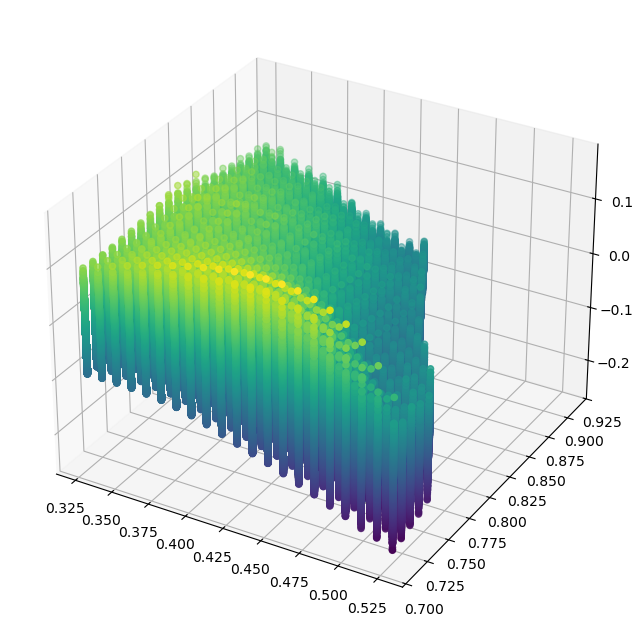

In [62]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Plot the data
ax.scatter(df["eta_1"], df["phi_11"], df["F"], c=df["F"], cmap="viridis", marker="o")


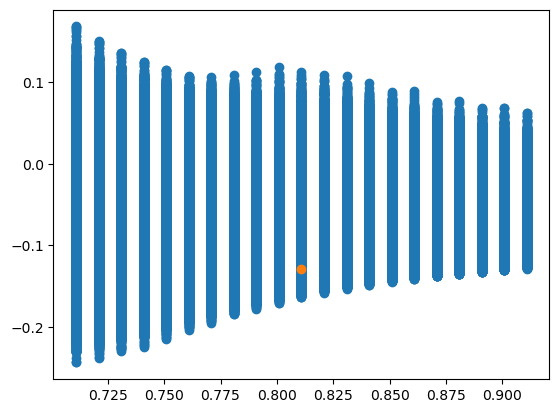

In [57]:
plt.scatter(df["phi_11"], df["F"])
plt.scatter(phases.fractions[0, 0], F)

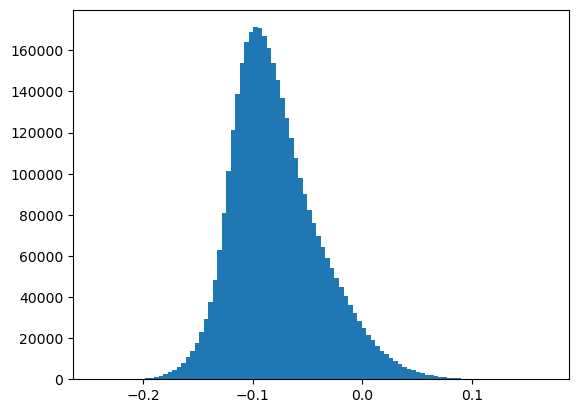

In [44]:
plt.hist(F_perturbed, bins = 100);

In [45]:
np.min(F)

-0.21247184594218244